In [1]:
import matplotlib
matplotlib.use('Agg')

import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib.pyplot as plt

#import matplotlib


#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal

import time
import ipywidgets as widgets

In [2]:
%matplotlib inline

In [5]:
## Set the path to your home directory here (e.g. /home/[username])
from os.path import expanduser
path = expanduser("~")

#big
# ts_dir = "downloads/Time_series_2020-07-06_16-31-46/"
# country_dir = "temp"
# download_dir = "1/"

#ts_dir = "downloads/Time_series_2020-07-07_11-51-35/"
#country_dir = "portugal_small"
#download_dir = "1/"

os.listdir(path + "/downloads/")
def f(time_series):
    return(path + "/downloads/" + time_series + "/1/")

#widgets.interact(f, time_series=widgets.Combobox(options=os.listdir(path + "/downloads/")));
w = widgets.interactive(f, time_series=widgets.Combobox(options=os.listdir(path + "/downloads/")))
w.children
type(w)

display(w)

interactive(children=(Combobox(value='', description='time_series', options=('gfc', 'Time_series_2020-07-10_13…

In [8]:
ts_dir = w.result
print(ts_dir)

/home/dven/downloads/Time_series_2020-07-07_11-51-35/1/


In [9]:
# download and parse input data

ifile_meta = "./data/"+ country_dir + "/dates.txt"
ifile_data = "./data/"+ country_dir + "/data.npy"


if not os.path.isdir("data/" + country_dir):
    os.makedirs("data/" + country_dir)

if not os.path.exists(ifile_meta):
    copyfile(ts_dir + "dates.csv", ifile_meta)


In [10]:
if not os.path.exists(ifile_data):
    start_time = time.time()
    image_file = os.path.join(ts_dir, 'stack.vrt') ## never start os path with a slash
    print(image_file)

    img = gdal.Open(image_file)
    print(img)

    
    cols = img.RasterXSize
    rows = img.RasterYSize

    print(f"Number of  bands: {img.RasterCount}")
    print(f"Number of pixels: {cols}")
    print(f"Number of  lines: {rows}")

    
    # Rewriting NANS to -32668 took 398.04383850097656 seconds for /home/dven/downloads/Time_series_2020-07-06_16-31-46/1/stack.vrt
    raster_stack = img.ReadAsArray()
    where_are_nans = np.isnan(raster_stack)
    raster_stack[where_are_nans] = -32768

    end_time = time.time()


    print("Transferring data and rewriting NANS to -32768 took {} seconds.".format(end_time - start_time))
    
    np.save(ifile_data,raster_stack)

In [46]:
# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
start_hist = datetime(2002, 1, 1)
start_monitor = datetime(2005, 1, 1)
end_monitor = datetime(2018, 1, 1)
position = (100,100)


In [27]:
#Fabians code
data_orig = np.load(ifile_data)
with open(ifile_meta) as f:
    dates_list = f.read().split('\n')
    dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]


In [28]:
def f(widget_start_monitor,widget_end_monitor):
    return widget_start_monitor, widget_end_monitor

#widgets.interact(f, widget_start_monitor=widgets.Combobox(options=dates_list, value=dates_list[1]));



layout = widgets.Layout(width='50', height='20px') #set width and height
selection_range_slider = widgets.SelectionRangeSlider(options = dates_list, 
                             description="Monitoring Period",
                             display="flex",
                             align_items="stretch",
                             layout = layout)

def print_date_range(date_range):
    return(date_range)

w = widgets.interactive(print_date_range,
    date_range=selection_range_slider
);

display(w)
x = w.result

interactive(children=(SelectionRangeSlider(description='Monitoring Period', index=(0, 0), layout=Layout(height…

In [29]:
x

()

In [30]:

    
data, dates = crop_data_dates(data_orig, dates, start_hist, end_monitor)
print("First date: {}".format(dates[0]))
print("Last date: {}".format(dates[-1]))
print("Shape of data array: {}".format(data.shape))

# memory errors, work in chunks? 



First date: 2002-01-29 00:00:00
Last date: 2018-01-01 00:00:00
Shape of data array: (391, 8, 14)


In [31]:
# fit BFAST using the CPU implementation (single pixel)

start_time = time.time()


model = BFASTMonitor(
            start_monitor,
            freq=freq,
            k=k,
            hfrac=hfrac,
            trend=trend,
            level=level,
            backend='python',
            verbose=1
            )

# only apply on a small subset
data = data[:,:20,:20]
model.fit(data, dates, nan_value=-32768)

end_time = time.time()
print("Fitting model took {} seconds.".format(end_time - start_time))


Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Fitting model took 0.811248779296875 seconds.


In [33]:
# select only negative magnitudes
breaks = model.breaks # index of date that has a break in dates
means = model.means # magnitudes of breaks

no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan


In [34]:
dates_monitor = []

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


In [47]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
    
print(idx_starts)
breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))

    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1
        continue
        
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
print(ticklist)
print(breaks_plot_years)

{2005: 0, 2006: 21, 2007: 36, 2008: 56, 2009: 75, 2010: 97, 2011: 112, 2012: 127, 2013: 139, 2014: 168, 2015: 200, 2016: 241, 2017: 282}
['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
[[ 6.  3.  0.  0.  0.  8. nan nan  8.  0.  0.  0.  0.  0.]
 [10.  6.  0.  0.  0. nan nan nan 10.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  4. nan nan  0.  0.  0.  0.  2. 10.]
 [ 1.  1.  0.  0.  0.  7.  7.  7.  7.  0.  5.  5.  2.  5.]
 [ 1.  0.  0.  0.  0.  8.  7.  7.  7.  7.  5.  5.  5.  5.]
 [ 0.  0.  0.  0.  0.  0.  8.  8.  3. nan  8.  8.  2.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  4.  8.  1.  1.  0.  0.]
 [nan  1.  7.  7.  3.  3.  0.  0.  0.  5.  2.  2.  0.  0.]]


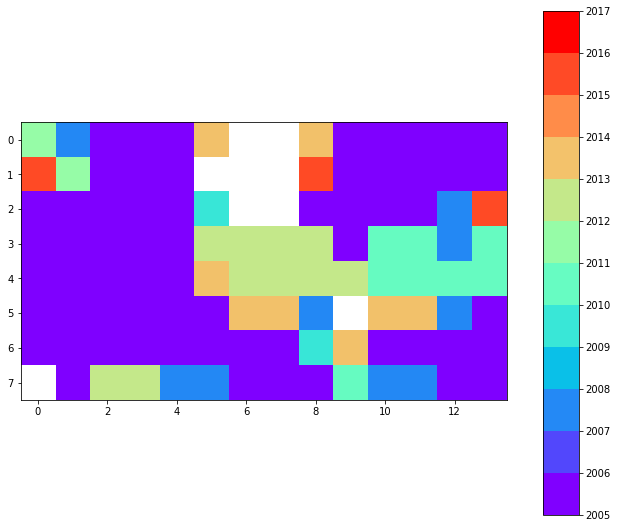

In [48]:
bins = len(idx_starts)

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(len(idx_starts)))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./picture.png")
plt.show()


In [77]:
# idx_start_2010 = np.argmax((dates_array >= datetime(2010, 1, 1)) > False) 
# idx_start_2011 = np.argmax((dates_array >= datetime(2011, 1, 1)) > False) # count how many dates do not come after 2011
# idx_start_2012 = np.argmax((dates_array >= datetime(2012, 1, 1)) > False) # this gives the index of the date starting in 
# idx_start_2013 = np.argmax((dates_array >= datetime(2013, 1, 1)) > False) # the respective year
# idx_start_2014 = np.argmax((dates_array >= datetime(2014, 1, 1)) > False)
# idx_start_2015 = np.argmax((dates_array >= datetime(2015, 1, 1)) > False)
# idx_start_2016 = np.argmax((dates_array >= datetime(2016, 1, 1)) > False)

# breaks_plot_years = copy.deepcopy(breaks_plot)
# breaks_plot_years[breaks_plot <= idx_start_2011] = 0
# breaks_plot_years[np.where(np.logical_and(idx_start_2011 < breaks_plot, breaks_plot <= idx_start_2012))] = 1
# breaks_plot_years[np.where(np.logical_and(idx_start_2012 < breaks_plot, breaks_plot <= idx_start_2013))] = 2
# breaks_plot_years[np.where(np.logical_and(idx_start_2013 < breaks_plot, breaks_plot <= idx_start_2014))] = 3
# breaks_plot_years[np.where(np.logical_and(idx_start_2014 < breaks_plot, breaks_plot <= idx_start_2015))] = 4
# breaks_plot_years[np.where(np.logical_and(idx_start_2015 < breaks_plot, breaks_plot <= idx_start_2016))] = 5
# breaks_plot_years[np.where(idx_start_2016 < breaks_plot)] = 6
# print(breaks_plot_years)

# cmap = plt.get_cmap("rainbow")
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# bounds = np.linspace(0, 6, 7) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
# norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
# im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=6, norm=norm)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax, ticks=[0, 1, 2, 3, 4, 5, 6])
# labels = cbar_ax.set_yticklabels(['2010', '2011', '2012', '2013', '2014', '2015', '2016'])

# plt.savefig("./picture.png")
# plt.show()
